(548, 700)


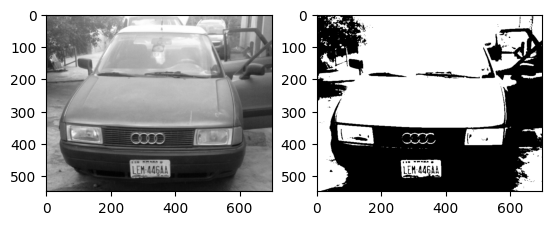

In [1]:
from skimage.io import imread
from skimage.filters import threshold_otsu
import matplotlib.pyplot as plt

car_image = imread("car6.jpg", as_gray=True) # read the image

print(car_image.shape)

grey_car_image = car_image*255 # convert the range to 0-255

fig, (ax1, ax2) = plt.subplots(1,2) # plot in 1 row and 2 columns

ax1.imshow(grey_car_image, cmap="gray") # plot the grey scale image
threshold_value = threshold_otsu(grey_car_image) # calculate the threshold value
binary_car_image = grey_car_image > threshold_value # check which pixel is above or below  the threshold
ax2.imshow(binary_car_image, cmap="gray") # plot the binary image
plt.show()

## Why do we need Thresholding?

In digital image processing, thresholding is the simplest method of segmenting images. It plays a crucial role in image processing as it allows for the segmentation and extraction of important information from an image. By dividing an image into distinct regions based on pixel intensity or pixel value, thresholding helps distinguish objects or features of interest from the background. This technique is widely used in various applications such as object detection, image segmentation, and character recognition, enabling efficient analysis and interpretation of digital images. Additionally, image thresholding can enhance image quality by reducing noise and improving overall visual clarity. This technique reduces the image to only two levels of intensity, making it easier to identify and isolate objects of interest.

Read more: https://encord.com/blog/image-thresholding-image-processing/#:~:text=It%20plays%20a%20crucial%20role,of%20interest%20from%20the%20background.

## Otsu's Method

Otsu's Method is a way to automatically find the best threshold value to separate the important parts of an image (foreground) from the less important parts (background).

Here’s how it works in simple terms:

1. Pixel Intensities: Every grayscale image has pixels with different shades, ranging from black (0) to white (255). These shades represent the intensity of the pixels.

2. Two Groups: Otsu's Method tries to divide all the pixels into two groups:

Foreground: The objects we care about (e.g., a car in the image).

Background: The rest of the image (e.g., the road, sky, etc.).

3. Choosing the Best Threshold:

The method tests different threshold values (different shades of gray) to split the pixels into two groups.
For each threshold, it calculates how "different" the two groups are from each other (this is called between-class variance).
The best threshold is the one that makes the difference between the two groups as big as possible.

4. Why It Works:

In images with clear distinctions between objects and background (like dark objects on a light background), pixel intensities often form two peaks (a bimodal distribution) in a histogram.
Otsu's Method finds the value between these peaks that best separates the two groups.

5. Result:

After determining the optimal threshold, the image is converted into a binary image:
White (foreground) for pixels above the threshold.

Black (background) for pixels below the threshold.

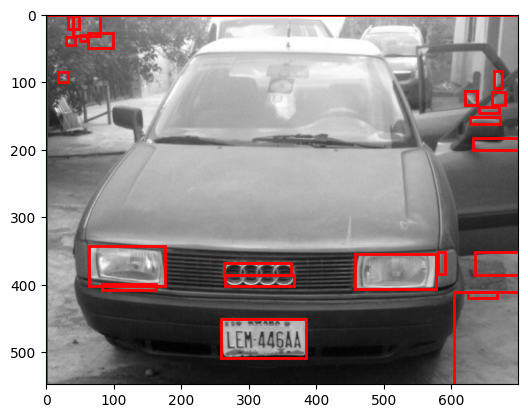

In [2]:
## Identify connected components and create a bounding box around them.

from skimage  import measure # From the skimage library, this is used for connected-component labeling.
from skimage.measure import regionprops # A function to extract properties (like area, bounding box, etc.) of connected regions.
import matplotlib.patches as patches # From matplotlib, used to draw shapes like rectangles on the image.

# get the connected regions in an image
label_image = measure.label(binary_car_image) # labels connected components
fig, (ax1) = plt.subplots(1)
ax1.imshow(grey_car_image, cmap="gray")

# list properties of all labelled regions
for region in regionprops(label_image): 
    if region.area<50:
        continue # region is too small for a license plate
    
    # the bounding box coordinates
    minRow, minCol, maxRow, maxCol = region.bbox # This property gives the bounding box of the region, which is a rectangle that surrounds the region.

    # (minRow, minCol): Top-left corner of the rectangle.
    # (maxRow, maxCol): Bottom-right corner of the rectangle.


    rectBorder = patches.Rectangle((minCol, minRow), maxCol-minCol, maxRow-minRow, edgecolor="red", linewidth=2, fill=False) # parameters - (top-left corner of the rectangle, width, height, border color, line width)
    ax1.add_patch(rectBorder)

plt.show()


## Connected Component Labeling

Connected-Component Labeling (CCL) is a technique in computer vision that helps identify and label different "connected regions" in a binary image (an image with only black and white pixels). Think of it as finding and naming groups of pixels that are connected to each other.

Here’s a simple explanation step-by-step:

**What’s a Connected Component?**

Imagine coloring on a grid with black and white squares. If you have a group of black squares touching each other (either side-to-side or diagonally), that group is a connected component.

**What Does CCL Do?**

CCL goes through the binary image and identifies all such groups of connected pixels.
Each group is given a unique label or number. For example:
Group 1 could be labeled as "1".
Group 2 could be labeled as "2".
And so on.
The output is a new image (called a "labeled image") where each pixel in a group has the same label.

**Why Is CCL Useful?**

CCL helps computers figure out where different objects or regions are in an image. For example:
Detecting objects in a photo.
Identifying blobs in medical images (like cells).
Counting items in an image (e.g., coins or stars).

**How Does It Work?**

CCL scans the image pixel by pixel, row by row.
It checks if a pixel is connected to its neighbors (based on a rule like 4-connectivity or 8-connectivity):
4-connectivity: A pixel is connected to the ones directly above, below, left, or right.
8-connectivity: A pixel is also connected to diagonal neighbors.
If a pixel is connected to others, it gets the same label as the group. If not, a new label is assigned.

**Real-Life Example:**

Think of an image with several black shapes on a white background. CCL will:
Identify each shape as a connected component.
Assign a unique number (or color) to each shape.

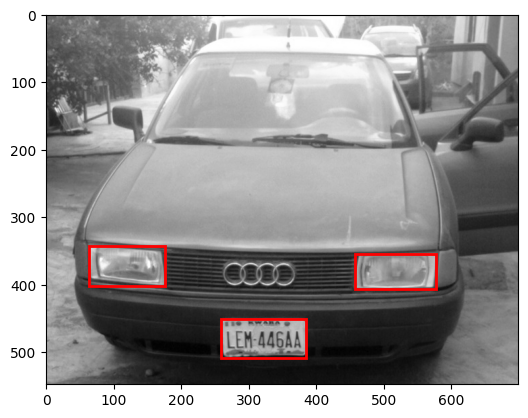

In [39]:
# get the connected regions
label_image = measure.label(binary_car_image)

# getting the max and min width height
plate_dims = (0.08*label_image.shape[0], 0.2*label_image.shape[0], 0.15*label_image.shape[1], 0.4*label_image.shape[1]) #(0.1*label_image.shape[0], 0.22*label_image.shape[0], 0.18*label_image.shape[1], 0.42*label_image.shape[1])
min_height, max_height, min_width, max_width = plate_dims

plate_coords = []
plate_like_objects = []

fig, (ax1) = plt.subplots(1)
ax1.imshow(grey_car_image, cmap="gray")

for region in regionprops(label_image):
    if region.area<50:
        continue

    min_row, min_col, max_row, max_col = region.bbox
    region_height = max_row-min_row
    region_width = max_col-min_col

    if region_height>=min_height and region_height<=max_height and region_width>=min_width and region_width<=max_width and region_width>region_height:
        plate_like_objects.append(binary_car_image[min_row:max_row, min_col:max_col])
        plate_coords.append((min_row, max_col, max_row, max_col))
        rectBorder = patches.Rectangle((min_col, min_row), max_col-min_col, max_row-min_row, edgecolor='red', linewidth=2, fill=False)
        ax1.add_patch(rectBorder)
plt.show()        

## Assumptions

1. A license plate (LP) width is greater than its height

2. LP takes a bout 8 to 20 % of the image height and 15 to 40% of the image width



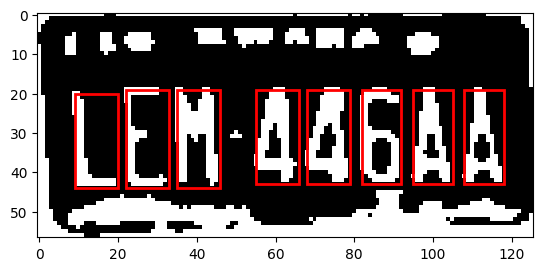

In [ ]:
import numpy as np
from skimage.transform import resize

license_plate = np.invert(plate_like_objects[2])
labeled_image = measure.label(license_plate)

fig, ax1 = plt.subplots(1)
ax1.imshow(license_plate, cmap="gray")

# size of the charcaters wrt to the license plate
character_dimensions = (0.35*license_plate.shape[0], 0.60*license_plate.shape[0], 0.05*license_plate.shape[1], 0.15*license_plate.shape[1])
min_height, max_height, min_width, max_width = character_dimensions

characters = []
counter = 0
column_list = []

for regions in regionprops(labeled_image):
    
    y0, x0, y1, x1 = regions.bbox
    region_height = y1 - y0
    region_width = x1 - x0

    if region_height > min_height and region_height < max_height and region_width > min_width and region_width < max_width:
        roi = license_plate[y0:y1, x0:x1]

        # draw a red bordered rectangle over the character.
        rect_border = patches.Rectangle((x0, y0), x1 - x0, y1 - y0, edgecolor="red",
                                       linewidth=2, fill=False)
        ax1.add_patch(rect_border)

        # resize the characters to 20X20 and then append each character into the characters list
        resized_char = resize(roi, (20, 20))
        characters.append(resized_char)

        # this is just to keep track of the position of characters for arrangement of the characters
        column_list.append(x0)

plt.show()


In [47]:
column_list

[22, 35, 55, 68, 82, 95, 108, 9]

## Projection Profile

Projection profile is calculated separately for different axis. Projection profile along vertical axis is called Vertical Projection profile. Vertical projection profile is calculated for every column as sum of all row pixel values inside the column. Horizontal Projection profile is the projection profile of a image along horizontal axis. Horizontal Projection profile is calculated for every row as sum of all column pixel values inside the row.

**Issue**

When identifying license plates in an image using the Connected Component Analysis (CCA) method, some unwanted regions like headlamps, stickers, or other similar-looking areas might also get mistakenly marked as license plates. These regions visually resemble a license plate but aren't one.

**Reason**


License plates and some other regions (like headlamps or stickers) can have similar shapes or features (like rectangular areas with high contrast), which makes it difficult for the algorithm to differentiate them just based on their appearance.

**Solution**

To better identify license plates, we can analyze the distribution of pixel values across the suspected regions. Here's how:

1. Add Pixel Values by Column:

Imagine slicing the suspected region vertically into columns.
Add up the pixel values in each column.

2. Why This Works:

A real license plate has characters written on it, meaning it will have alternating patterns of white (bright areas) and black (dark areas).
This results in many pixels being present in the middle part of the plate.
Other objects like headlamps or stickers won’t have this kind of structure, so their vertical projection won’t show the same pattern.

3. Filtering Out False Positives:

If a region’s vertical projection doesn’t show the expected dense pixel distribution (like that of a license plate), it can be eliminated as a false positive.